In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
X_train = pd.read_csv("Corona_NLP_train.csv",encoding='ISO-8859-1')

In [45]:
X_test = pd.read_csv("Corona_NLP_test.csv",encoding='ISO-8859-1')
X_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [46]:
X_train = X_train.fillna("unknown")
X_test = X_test.fillna("unkonwn")


In [47]:
X_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,unknown,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [48]:
X_train.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Location'>

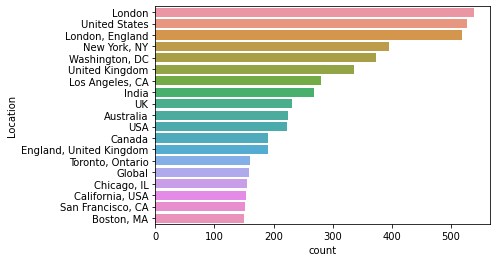

In [49]:
sns.countplot(y = 'Location',data = X_train,order = X_train.Location.value_counts().iloc[1:20].index)

<AxesSubplot:xlabel='count', ylabel='Location'>

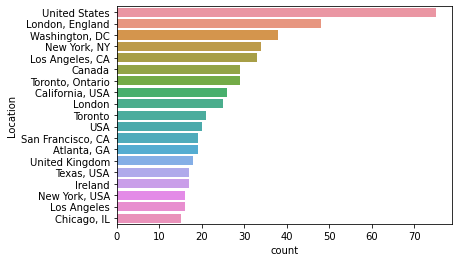

In [50]:
sns.countplot(y = 'Location',data = X_test,order = X_test.Location.value_counts().iloc[1:20].index)

In [51]:
stop_words = stopwords.words('english')
def clean_data(text):
    text = re.sub(r'http\S+',' ',text)
    text = re.sub(r'<.*?>',' ',text)
    text = re.sub(r'\d+',' ',text)
    text = re.sub(r'#\w+',' ',text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'$|\£','money',text)
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    return text

In [52]:
X_train["OriginalTweet"] = X_train["OriginalTweet"].apply(clean_data)

In [53]:
X_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,money,Neutral
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,Positive
3,3802,48754,unknown,16-03-2020,"My food stock one empty... PLEASE, panic, THER...",Positive
4,3803,48755,unknown,16-03-2020,"Me, ready go supermarket outbreak. Not I'm par...",Extremely Negative


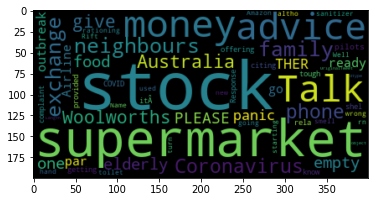

In [56]:
ws = WordCloud()
ws.generate(str(X_train["OriginalTweet"]))
plt.imshow(ws, interpolation='bilinear')

In [57]:
X_train['target'] = X_train["Sentiment"]

In [58]:
X_train['target'].replace({'Neutral':0,'Extremely Negative':1,'Negative':1,'Positive':2,'Extremely Positive':2},inplace=True)

In [59]:
X_test['target'] = X_test["Sentiment"]
X_test['target'].replace({'Neutral':0,'Extremely Negative':1,'Negative':1,'Positive':2,'Extremely Positive':2},inplace=True)

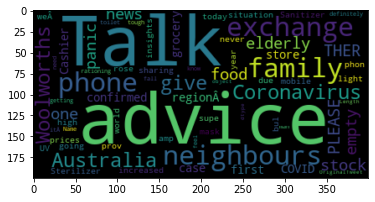

In [61]:
ws = WordCloud()
ws.generate(str(X_train[X_train['target']==2]['OriginalTweet']))
plt.imshow(ws, interpolation='bilinear')

In [62]:
x_train = X_train["OriginalTweet"]
y_train = X_train["target"]
x_test = X_test["OriginalTweet"]
y_test = X_test["target"]

In [63]:
max_len = np.max(x_train.apply(lambda x :len(x)))
print(max_len)

292


In [65]:
tokenizer = Tokenizer()

In [66]:
tokenizer.fit_on_texts(x_train)

In [70]:
vocab_length = len(tokenizer.word_index) + 1

In [72]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [79]:
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [85]:
from keras.utils import to_categorical

In [87]:
y_train = to_categorical(y_train,3)

In [90]:
y_test = to_categorical(y_test,3)

In [92]:
from keras.models import Sequential

In [93]:
from keras.layers import Dense

In [94]:
import tensorflow as tf

In [99]:

embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')     
])

In [100]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
history = model.fit(x_train,y_train,epochs=10,batch_size=64, validation_data=(x_test,y_test))

Epoch 1/10
644/644 [==============================] - 153s 237ms/step - loss: 0.9828 - accuracy: 0.4867 - val_loss: 0.8279 - val_accuracy: 0.6143
Epoch 2/10
644/644 [==============================] - 158s 245ms/step - loss: 0.6282 - accuracy: 0.7582 - val_loss: 0.5783 - val_accuracy: 0.7817
Epoch 3/10
644/644 [==============================] - 166s 257ms/step - loss: 0.3792 - accuracy: 0.8804 - val_loss: 0.5658 - val_accuracy: 0.8062
Epoch 4/10
644/644 [==============================] - 154s 239ms/step - loss: 0.2640 - accuracy: 0.9213 - val_loss: 0.5706 - val_accuracy: 0.8128
Epoch 5/10
644/644 [==============================] - 162s 252ms/step - loss: 0.1985 - accuracy: 0.9420 - val_loss: 0.5990 - val_accuracy: 0.8136
Epoch 6/10
644/644 [==============================] - 157s 243ms/step - loss: 0.1646 - accuracy: 0.9525 - val_loss: 0.7248 - val_accuracy: 0.7962
Epoch 7/10
644/644 [==============================] - 165s 256ms/step - loss: 0.1376 - accuracy: 0.9596 - val_loss: 0.7591 -

In [104]:
pred = model.predict_classes(x_test)

In [109]:
from sklearn.metrics import accuracy_score,classification_report

In [111]:
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       619
           1       0.74      0.88      0.80      1633
           2       0.87      0.71      0.78      1546

    accuracy                           0.78      3798
   macro avg       0.77      0.76      0.76      3798
weighted avg       0.79      0.78      0.78      3798



In [112]:
print(accuracy_score(np.argmax(y_test,1),pred))

0.778041074249605


In [113]:
type(pred)

numpy.ndarray

In [114]:
type(y_test)

numpy.ndarray

In [116]:
accuracy_score(np.argmax(y_test,1),pred) 

0.778041074249605